<a href="https://colab.research.google.com/github/trhgquan/CS156/blob/main/sentiment_analysis/danh_gia_mon_hoc_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing libraries

In [45]:
!pip install underthesea
!pip install imbalanced-learn

In [51]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from underthesea import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

## Extracting and creating dataset

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/danh_gia_mon_hoc_rating/UIT-VSFC.zip" "/content/UIT-VSFC.zip"
!cp "/content/drive/MyDrive/Colab Notebooks/danh_gia_mon_hoc_rating/stopwords.txt" "/content/stopwords.txt"

def extracting_file():
    with zipfile.ZipFile('/content/UIT-VSFC.zip', 'r') as zfile:
        zfile.extractall('/content/data')

extracting_file()

In [5]:
stopwords = []

with open('stopwords.txt', 'r+', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

print(len(stopwords))

1942


In [23]:
def create_frame(sentences, labels):
    result = {
        'sentences': sentences,
        'labels': labels
    }
    return pd.DataFrame(result)

In [7]:
def preprocess(sentence):
    sentence = sentence.strip()
    sentence = sentence.replace(',', '')
    sentence = sentence.replace('.', '')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('!', '')
    sentence = sentence.replace('  ', ' ')
    return sentence.lower().strip()

In [8]:
def tokenize(sentence):
    return word_tokenize(sentence, format = 'word')

In [25]:
train_sentences, train_labels = [], []

with open('/content/data/UIT-VSFC/train/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        train_sentences.append(preprocess(line))

with open('/content/data/UIT-VSFC/train/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        train_labels.append(int(line.strip()))

2    5643
0    5325
1     458
Name: labels, dtype: int64

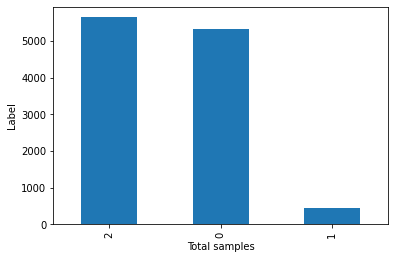

In [43]:
train_dataset = create_frame(train_sentences, train_labels)
count = train_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total samples')
plt.show()

In [26]:
test_sentences, test_labels = [], []

with open('/content/data/UIT-VSFC/test/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        test_sentences.append(preprocess(line))

with open('/content/data/UIT-VSFC/test/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        test_labels.append(int(line.strip()))


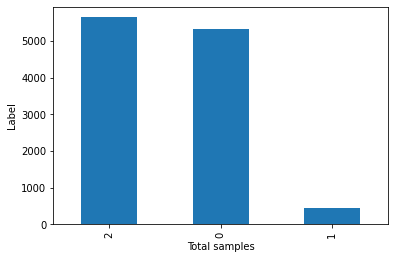

In [44]:
test_dataset = create_frame(test_sentences, test_labels)
test_dataset['labels'].value_counts()
count = train_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total samples')
plt.show()


In [11]:
dev_sentences, dev_labels = [], []

with open('/content/data/UIT-VSFC/test/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        dev_sentences.append(preprocess(line))

with open('/content/data/UIT-VSFC/test/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        dev_labels.append(int(line.strip()))

# dev_dataset = create_frame(dev_sentences, dev_labels)

In [52]:
oversample = RandomOverSampler(sampling_strategy = 'minority')

In [53]:
vectorizer = CountVectorizer(
    stop_words = stopwords,
    tokenizer = tokenize
)

In [55]:
X = vectorizer.fit_transform(train_sentences)
y = train_labels

X_over, y_over = oversample.fit_resample(X, y)

X_test = vectorizer.transform(test_sentences)
y_test = test_labels

model = MultinomialNB()
model.fit(X_over, y_over)


MultinomialNB()

In [76]:
print(model.score(X_test, y_test))

0.7504737839545167


In [86]:
sentences = [
    'thầy dạy rất hay',
    'không ai hướng dẫn, toàn phải tự lực cánh sinh',
    'thầy toàn đọc slide, không giảng bài',
    'phí tiền khi học lớp này',
    'học phí quá cao, cô lại dạy dở, không ai hỗ trợ',
    'trợ giảng rất nhiệt tình',
    'thầy giảng hay, nhưng bài tập rất khó'
]

for s in sentences:
    predict_ = model.predict(vectorizer.transform([preprocess(s)]))
    
    labels = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    print(s, labels[predict_[0]])

thầy dạy rất hay POSITIVE
không ai hướng dẫn, toàn phải tự lực cánh sinh NEGATIVE
thầy toàn đọc slide, không giảng bài NEGATIVE
phí tiền khi học lớp này NEGATIVE
học phí quá cao, cô lại dạy dở, không ai hỗ trợ NEGATIVE
trợ giảng rất nhiệt tình POSITIVE
thầy giảng hay, nhưng bài tập rất khó POSITIVE
